In [ ]:
#!/usr/bin/python

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def normalize_image(img: np.ndarray, threshold: float = 0.1):
    """
    normalize the image to be between 0 and 1
    """
    dims = img.shape
    env = np.ones(dims)
    z = np.where(img < threshold)
    env[z] = 0.0
    return env


def plot_enviroment(img: np.ndarray, obj: np.ndarray, state: tuple):
    """
    @param img: original image in 2d
    @param obj: is the 3d array of different configurations
    @param state: is the curent pose (x, y, orientation) of the object

    @return: the merged image
    """
    dims = obj.shape
    dim_x = int((dims[0] - 1) / 2)
    dim_y = int((dims[1] - 1) / 2)
    merged_img = np.copy(img)
    merged_img[state[0] - dim_x:state[0] + dim_x + 1, state[1] - dim_y:state[1] + dim_y + 1] += obj[:, :, state[2]] * 0.5
    return merged_img


def plotting_results(environment: np.ndarray, rod: np.ndarray, plan: list, save_path: str = 'rod_solve.mp4'):
    """
    create an animation of the plan and save it to a file

    @param environment: the environment image in 2d
    @param rod: is the 3d array of different configuration
    @param plan: list of poses
    @param save_path: path to save the animation
    """

    fig = plt.figure()
    imgs = []

    for s in plan:
        im = plot_enviroment(environment, rod, s)
        plot = plt.imshow(im)
        imgs.append([plot])

    ani = animation.ArtistAnimation(fig, imgs, interval=50, blit=True)

    ani.save(save_path)

    plt.show()


In [ ]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=def241ff2693d98701844ba4d438026216b6b782fc37954832fcb8fdb1dcc24a
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [ ]:
from utils import *
from scipy.signal import convolve2d

In [ ]:
with np.load("data_ps1.npz") as data:
    environment = data['environment']
    rod = data['rod']

In [ ]:
rod

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.],
      

In [ ]:
environment

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

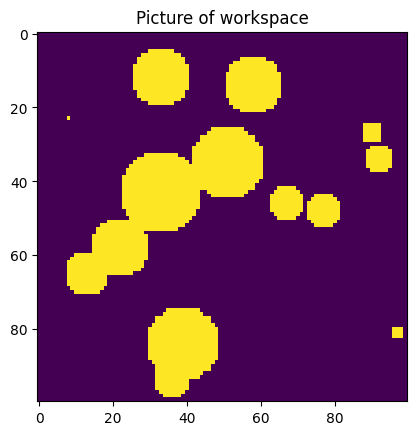

In [ ]:
plt.title('Picture of workspace')
plt.imshow(environment)

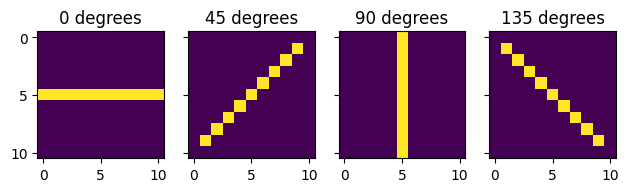

In [ ]:
f, ax = plt.subplots(1, 4, sharey=True)
for i in range(4):
    ax[i].imshow(rod[:, :, i])
    ax[i].set_title(f'{i*45} degrees')
plt.tight_layout()
plt.show()

We are starting here


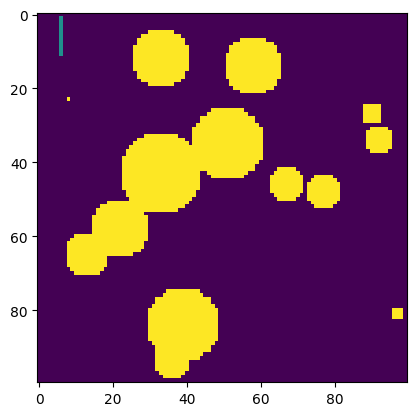

In [ ]:
print('We are starting here')
plt.imshow(plot_enviroment(img=environment, obj=rod, state=(6, 6, 2)))

We want to get here


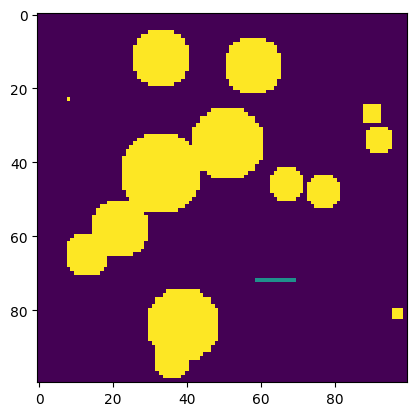

In [ ]:
print('We want to get here')
plt.imshow(plot_enviroment(img=environment, obj=rod, state=(72, 64, 0)))

0 degrees (100, 100, 4)
45 degrees (100, 100, 4)
90 degrees (100, 100, 4)
135 degrees (100, 100, 4)


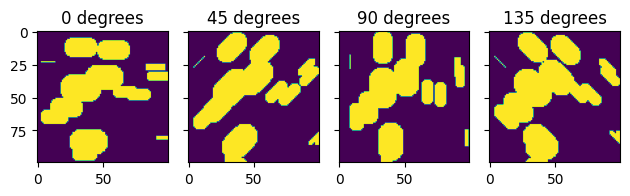

In [ ]:
f, ax = plt.subplots(1, 4, sharey=True)
C = np.zeros((environment.shape[0], environment.shape[1], 4))
for i in range(4):
    tmp228 = normalize_image(convolve2d(environment, rod[:, :, i], boundary='symm', mode='same'))
    C[:, :, i] = tmp228
    print(f'{i*45} degrees', C.shape)
    ax[i].imshow(tmp228)
    ax[i].set_title(f'{i*45} degrees')
plt.tight_layout()
plt.show()

In [ ]:
def recursive_planning(x, parent_table, plan, x0):
    if x == x0:
        return plan
    else:
        plan.append(parent_table[x])
        return recursive_planning(parent_table[x], parent_table, plan, x0)

In [ ]:
def A_star(x0, final_point, C, my_func):
    tmp = []
    visited_places = []
    tmp.append((x0, 0))
    conf_cost = {x0: 0}
    parent_table = {}

    i = 0
    while len(tmp) != 0:
        tmp = sorted(tmp, key = lambda temp: temp[1])
        tmp228 = tmp.pop(0)
        x = tmp228[0]
        if x == final_point:
            plan = list(reversed(recursive_planning(x, parent_table, [x], x0)))
            final_cost = conf_cost[x]
            results = {'plan': plan, 'cost': final_cost, 'iterations': i}
            print(f'Final cost: {final_cost}, number of iterations: {i}')
            return results

        a = x[0]
        b = x[1]
        c = x[2]

        available_steps = []
        up = (a - 1, b, c)
        down = (a + 1, b, c)
        left = (a, b - 1, c)
        right = (a, b + 1, c)


        # since size is 100 and we cannot go closer than 6 steps we have following if conditions
        if a >= 6 and C[up] != 1:
            available_steps.append(up)

        if a <= 93 and C[down] != 1:
            available_steps.append(down)

        if b >= 6 and C[left] != 1:
            available_steps.append(left)

        if b <= 93 and C[right] != 1:
            available_steps.append(right)

        rotation = np.roll([0,1,2,3], -c)
        rotate1 = (a, b, np.roll(rotation, -1)[0])
        rotate2 = (a, b, np.roll(rotation, 1)[0])

        if C[rotate1] != 1:
            available_steps.append(rotate1)
        if C[rotate2] != 1:
            available_steps.append(rotate2)


        for j in available_steps:
            if not j in visited_places:
                visited_places.append(j)
                parent_table[j] = x
                conf_cost[j] = conf_cost[x] + 1
                tmp.append((j, conf_cost[j] + my_func(j, final_point)))
            elif conf_cost[j] > conf_cost[x] + 1:
                conf_cost[j] = conf_cost[x] + 1
                parent_table[j] = x
        i += 1

Dijkstra algorithm

Final cost: 126, number of iterations: 14269


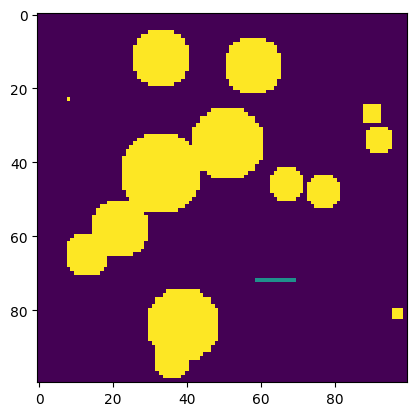

In [ ]:
x0 = (6, 6, 2)
final_point = (72, 64, 0)

results = A_star(x0, final_point, C, lambda i, j: 0)
plotting_results(environment, rod, results['plan'], 'rod_Dijkstra.gif')

A_star

Final cost: 126, number of iterations: 3941


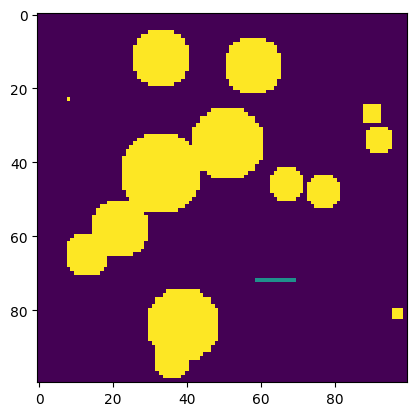

In [ ]:
results = A_star(x0, final_point, C, lambda i, j: np.abs(np.array(i)[:2] - np.array(j)[:2]).sum())
plotting_results(environment, rod, results['plan'], 'rod_A_star.gif')

We greatly decreased number of iterations but final cost din't changed

A_star with rotation

Final cost: 126, number of iterations: 3400


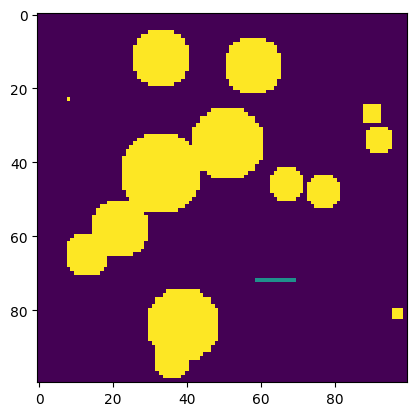

In [ ]:
from numpy import linalg
from scipy.linalg import logm

# let's use function from seminar1
def log_rotations(x_sub, final_point):
    l1 = np.abs(np.array(x_sub)[:2] - np.array(final_point)[:2]).sum()
    angle1, angle2 = x_sub[-1], final_point[-1]
    r1 = np.array([[np.cos(angle1), -np.sin(angle1)], [np.sin(angle1), np.cos(angle1)]])
    r2 = np.array([[np.cos(angle2), -np.sin(angle2)], [np.sin(angle2), np.cos(angle2)]])
    return l1 + linalg.norm(logm(r1 @ r2.T))

results = A_star(x0, final_point, C, log_rotations)
plotting_results(environment, rod, results['plan'], 'rod_A_star_with_log.gif')

We used heuristic function from seminar which decreased number of iterations even more